Python notebook to extract aster contraction rates from motor fluorescence channel.

## Imports

In [1]:
#for reading files
import glob

#math computation and data organization
import numpy as np
import scipy
import pandas as pd

# For loading bars
from tqdm.notebook import tqdm as tqdm

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian, threshold_mean
from skimage.measure import regionprops
import cv2

#for fitting
from lmfit import minimize, Parameters, fit_report

#for image registration
from skimage.registration import phase_cross_correlation
import os

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import gridspec

#Movie
import celluloid as cell
import matplotlib.animation as animation

#for saving data
import csv

#custom analysis packages
import aster_packages as ap

# impory copy
import copy

import bokeh
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider
from bokeh.plotting import ColumnDataSource, figure, show
bokeh.io.output_notebook()


Loading BokehJS ...

Figure design based on rp package

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

# Figure Formatting
import matplotlib.pyplot as plt
import matplotlib as mpl

figwidth = 4
plt.rcParams["figure.figsize"] = [figwidth, figwidth * 1105 / 1920
                                  ]  # figure size in inches
plt.rcParams["lines.linewidth"] = 2  # line width in points
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

plt.rcParams["font.style"] = "normal"
plt.rcParams["font.weight"] = "heavy" #chick this later maybe the source of weirdness in labels (ANA READ THIS)
plt.rcParams["font.size"] = 13.0
plt.rcParams["axes.labelweight"] = "bold"  # weight of the x and y labels
plt.rcParams["axes.spines.right"] = True
plt.rcParams[
    "axes.formatter.useoffset"] = True  # If True, the tick label formatter
plt.rcParams["xtick.major.size"] = 10  # major tick size in points
plt.rcParams["xtick.minor.size"] = 4  # minor tick size in points
plt.rcParams["xtick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.major.size"] = 10  # major tick size in points
plt.rcParams["ytick.minor.size"] = 4  # minor tick size in points
plt.rcParams["ytick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["legend.fontsize"] = 10
plt.rcParams[
    "legend.labelspacing"] = 0.1  # the vertical space between the legend entries in fraction of fontsize
plt.rcParams["legend.shadow"] = False
plt.rcParams[
    "legend.frameon"] = True  # whether or not to draw a frame around legend
plt.rcParams[
    'axes.unicode_minus'] = False  # fix glyph error by using normal hyphens
plt.rcParams.update({"text.usetex": True, 
             "font.family": "Times"})
mpl.rc("figure", dpi=200)

color_background = '#E5E0D5'

## Read Data

In [22]:
# Provide filepath
datapath = '../../data/aster/'
datafolders = ['20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif']

#Choose the channels of interest (Write in the order of bound, unbound, motor, mt)
channel_list = ['405', '480', 'Cherry']
channel_id = ['bnd', 'unbnd', 'mot'] #Don't change these names

#included frames
included_frames = '*ome*.tif'


In [23]:
i = 0; 
images = ap.file_to_image([datapath + datafolders[i]]); 
bound_images = images[0, :, :, :, 0]; # Assuming last channel is motors from checking in Fiji - crosscheck.
unbound_images = images[0, :, :, :, 1]; # Assuming last channel is motors from checking in Fiji - crosscheck.
cherry_motor_images = images[0, :, :, :, 2]; # Assuming last channel is motors from checking in Fiji - crosscheck.

OME series: not an ome-tiff master file


In [5]:
normalise_image = lambda image: (image - np.amin(image))/(np.amax(image) - np.amin(image))

## Extract contraction rates

### Function to extract area of a single motor channel image

In [6]:
def motor_channel_contour(binary): 
   
    # Create a contour
    contours, hierarchy = cv2.findContours(binary, 1, 2)

    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None

    #Find the contour that encomppasses the largest area, this will be the best center circle guess
    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j

    (x,y),radius = cv2.minEnclosingCircle(contours[max_index])
    center = (int(x),int(y))
    radius = int(radius)

    print("radius: ", radius)
    
    return center, radius


def preprocess_image(microscopy_image, microscopy_image0, isPlot = False): 
    # Create square mask
    square_mask = np.zeros(cherry_motor_images[0].shape)
    centre_x = int(square_mask.shape[0]/2)
    centre_y = int(square_mask.shape[1]/2)
    half_length = 400; 
    square_mask[centre_x-half_length : centre_x + half_length, centre_y-half_length : centre_y+half_length ] = 1; 

    # Copy images and apply square mask
    image = copy.deepcopy(microscopy_image*square_mask); 
    image0 = copy.deepcopy(microscopy_image0*square_mask); 
    
    difference_image = (microscopy_image - microscopy_image0)*square_mask
    thresh1 = np.percentile(difference_image, q = 0.01); 
    thresh2 = np.percentile(difference_image, q = 99);

    difference_image[difference_image < thresh1] = thresh1; 
    difference_image[difference_image > thresh2] = thresh2; 

    difference_image = normalise_image(difference_image)

    plt.figure()
    plt.imshow(difference_image)
    plt.title("Difference Image")


    # if isPlot:
    #     plt.imshow(image)
    #     plt.title("Raw Image")

    thresh1 = np.percentile(image, q = 0.01); 
    thresh2 = np.percentile(image, q = 99); 
    image[image < thresh1] = thresh1; 
    image[image > thresh2] = thresh2; 
    # image = normalise_image(image); 

    thresh1 = np.percentile(image0, q = 0.01); 
    thresh2 = np.percentile(image0, q = 99); 
    image0[image0 < thresh1] = thresh1; 
    image0[image0 > thresh2] = thresh2; 
    # image0 = normalise_image(image0); 

    if isPlot:
        fig2, ax2 = plt.subplots() # note we must use plt.subplots, not plt.subplot
        plt.imshow(normalise_image(image))
        plt.title("Threshold Corrected and Normalised")

        # fig2, ax2 = plt.subplots() # note we must use plt.subplots, not plt.subplot
        # plt.imshow(scipy.ndimage.gaussian_filter(image, 20))
        # plt.title("Gaussian smoothed")

        # fig2, ax2 = plt.subplots() # note we must use plt.subplots, not plt.subplot
        # plt.imshow(image0)
        # plt.title("Threshold Corrected and Normalised, Image0")

        # fig2, ax2 = plt.subplots() # note we must use plt.subplots, not plt.subplot
        # plt.imshow(normalise_image(image - image0))
        # plt.title("Initial Image Subtracted")
    
    for sigma in np.arange(10, 50, 10): 
        log_image = scipy.ndimage.gaussian_laplace(difference_image, sigma); 
        # max_log_image = np.amax(log_image); 
        # max_log_image_index = np.where(log_image == max_log_image); 
        log_image[log_image >= 0] = 0; 
        log_image[log_image < 0] = 1; 

        # log_image = normalise_image(log_image); 

        if isPlot:
            fig2, ax2 = plt.subplots() # note we must use plt.subplots, not plt.subplot
            plt.imshow(log_image
                    #    , alpha = 0.3
                    )
            plt.title(f"Laplacian of Gaussian Applied, sigma = {sigma}")

            fig2, ax2 = plt.subplots() # note we must use plt.subplots, not plt.subplot
            plt.imshow(difference_image*log_image
                    #    , alpha = 0.3
                    )
            plt.title(f"Image multiplied Laplacian of Gaussian Applied, sigma = {sigma}")

    # canny_edge_image = ~skimage.feature.canny(image, sigma = 1); 
    # canny_edge_image = canny_edge_image
    
    # if isPlot:
    #     plt.figure()
    #     plt.imshow(canny_edge_image)
    #     plt.title(f"Canny Edge Detector, sigma = {1}")

    # erode_image = scipy.ndimage.binary_erosion(canny_edge_image)
    # if isPlot:
    #     plt.figure()
    #     plt.imshow(erode_image)
    #     plt.title(f"Erode Image")

    return log_image.astype(np.uint8)

In [8]:
square_mask = np.zeros(cherry_motor_images[0].shape)
centre_x = int(square_mask.shape[0]/2)
centre_y = int(square_mask.shape[1]/2)
half_length = 300;
square_mask[centre_x-half_length : centre_x + half_length, centre_y-half_length : centre_y+half_length ] = 1; 

# plt.figure()
# plt.imshow(square_mask*cherry_motor_images[100]); 
# plt.show()

In [ ]:
%matplotlib qt

# selected_image_pairs = np.array([cherry_motor_images[i:i+2] for i in [0, 50]]); 
# print(selected_images)

# for pair in selected_image_pairs:

image0 = cherry_motor_images[0]; 
for image in cherry_motor_images[2:3]:
    

    # difference_image = normalise_image(image - image0)
    # thresh1 = np.percentile(difference_image, q = 0.01); 
    # thresh2 = np.percentile(difference_image, q = 99);

    # difference_image[difference_image < thresh1] = thresh1; 
    # difference_image[difference_image > thresh2] = thresh2; 

    # plt.figure()
    # plt.imshow(difference_image)
    # plt.title("Difference Image")

    binarized_image = preprocess_image(image, image0, isPlot=True); 

    # center, radius = motor_channel_contour(binarized_image)

    # fig2, ax2 = plt.subplots() # note we must use plt.subplots, not plt.subplot
    # plt.imshow(image, 
    #         vmin = np.percentile(image, q = 10), 
    #         vmax = np.percentile(image, q = 99))
    # circle1 = plt.Circle(center, radius, color='r', alpha = 0.5)
    # ax2.add_patch(circle1)
    break


plt.show()

(array([[  0.,   0.,   0., ...,   0., 900.,   0.],
        [  0.,   0.,   0., ...,   0., 900.,   0.],
        [  0.,   0.,   0., ...,   0., 900.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0., 900.,   0.],
        [  0.,   0.,   0., ...,   0., 900.,   0.],
        [  0.,   0.,   0., ...,   0., 900.,   0.]]),
 array([-32592. , -28505.6, -24419.2, -20332.8, -16246.4, -12160. ,
         -8073.6,  -3987.2,     99.2,   4185.6,   8272. ]),
 <a list of 900 BarContainer objects>)

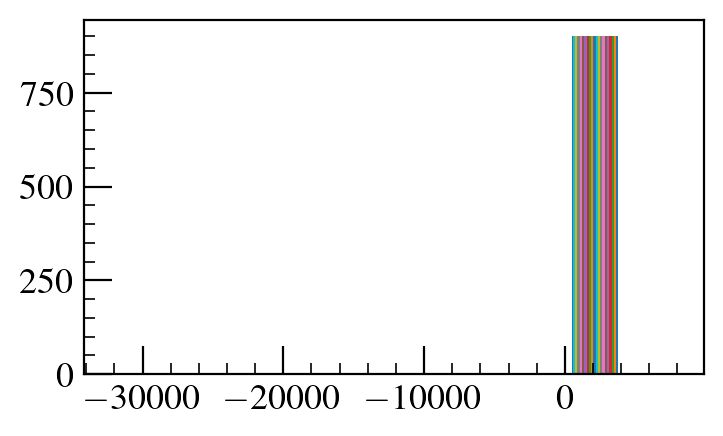

In [13]:
plt.hist(cherry_motor_images[30][centre_x-half_length : centre_x + half_length, centre_y-half_length : centre_y+half_length]); 

In [43]:
%matplotlib qt


In [165]:
import scipy.ndimage


half_length = 450; 
image = copy.deepcopy(cherry_motor_images[50][centre_x-half_length : centre_x + half_length, centre_y-half_length : centre_y+half_length])
# image[image < np.percentile(image, q = 10)] = np.percentile(image, q = 10); 
# image[image > np.percentile(image, q = 99)] = np.percentile(image, q = 99); 

image0 = copy.deepcopy(cherry_motor_images[0][centre_x-half_length : centre_x + half_length, centre_y-half_length : centre_y+half_length])
# image0[image0 < np.percentile(image0, q = 10)] = np.percentile(image0, q = 10); 
# image0[image0 > np.percentile(image0, q = 99)] = np.percentile(image0, q = 99); 

plt.figure()
plt.imshow(image, 
           vmin = np.percentile(image, q = 10), 
           vmax = np.percentile(image, q = 99),
           )
plt.title("Image")

plt.figure()
plt.imshow(image0, 
           vmin = np.percentile(image, q = 10), 
           vmax = np.percentile(image, q = 99),
           )
plt.title("Image0, contrasted")

difference = image - image0; 
difference[difference < 0] = 0
# difference[difference < np.percentile(difference, q = 10)] = np.percentile(difference, q = 10); 
# difference[difference > np.percentile(difference, q = 99)] = np.percentile(difference, q = 99);

difference[difference < np.percentile(difference, q = 99)] = 0; 
difference[difference >= np.percentile(difference, q = 99)] = 1; 


# difference = normalise_image(difference)

plt.figure()
plt.imshow((difference), 
        #    vmin = np.percentile(difference, q = 10), 
        #    vmax = np.percentile(difference, q = 99),
           )
plt.title("Difference")

# # Edge detection
# edges = skimage.feature.canny(image, sigma=100)
# plt.figure()

# plt.imshow((edges), 
#         #    vmin = np.percentile(difference, q = 10), 
#         #    vmax = np.percentile(difference, q = 99),
#            )
# plt.title("edges")

#Fill Holes
# eroded = scipy.ndimage.morphology.binary_erosion(difference)
binary_fillholes = scipy.ndimage.binary_dilation(difference, iterations=2)
plt.figure()

plt.imshow((binary_fillholes), 
        #    vmin = np.percentile(difference, q = 10), 
        #    vmax = np.percentile(difference, q = 99),
           )
plt.title("eroded then dilated")

# plt.figure()
# plt.hist(difference)
# plt.yline(np.percentile(difference, q = 90))

# plt.figure()
# plt.imshow((difference), vmin = 0, vmax = 1)
# plt.title("Difference, Normalised")

log_image = scipy.ndimage.gaussian_laplace(binary_fillholes, 50); 
log_image[log_image >= 0] = 0; 
log_image[log_image < 0] = 1; 
# log_image = log_image.astype(np.uint8)


# print(np.amax(log_image), np.amin(log_image))
plt.figure()
plt.imshow((log_image))
plt.title("log_image")

# center, radius = motor_channel_contour(log_image); 
# # fig2, ax2 = plt.subplots() # note we must use plt.subplots, not plt.subplot
# # # plt.imshow((image))
# # plt.imshow((difference))
# # circle1 = plt.Circle(center, radius, color='r', alpha = 0.05)
# # ax2.add_patch(circle1)
# # plt.show()

# # fig2, ax2 = plt.subplots() # note we must use plt.subplots, not plt.subplot
# # plt.imshow((log_image))
# # circle1 = plt.Circle(center, radius, color='r', alpha = 0.05)
# # ax2.add_patch(circle1)
# # plt.show()

# # fig2, ax2 = plt.subplots() # note we must use plt.subplots, not plt.subplot
# # plt.imshow((image))
# # plt.imshow((log_image), alpha = 0.05, cmap='Reds_r')
# # plt.show()
# binary_fillholes = binary_fillholes.astype(np.uint8)
# dist = cv2.distanceTransform((binary_fillholes), cv2.DIST_L2, 0)
# NULL,max_val,NULL,max_indx=cv2.minMaxLoc(dist)

# (x,y),radius = max_indx, max_val

# fig2, ax2 = plt.subplots() # note we must use plt.subplots, not plt.subplot
# plt.imshow((binary_fillholes))
# circle1 = plt.Circle((x,y), radius, color='r', alpha = 1)
# ax2.add_patch(circle1)
# plt.title("Max Inscribed Circle")
# plt.show()


Text(0.5, 1.0, 'log_image')

: 

In [151]:
radius

8.062257766723633

In [ ]:
dummy_image = normalise_image(cherry_motor_images[3] - cherry_motor_images[0]); 
thresh1 = np.percentile(dummy_image, q = 0.01); 
thresh2 = np.percentile(dummy_image, q = 99); 
dummy_image[dummy_image < thresh1] = thresh1; 
dummy_image[dummy_image > thresh2] = thresh2; 

plt.figure()
plt.hist(dummy_image)

thresh = threshold_otsu(image)
binary = dummy_image > thresh
plt.figure()
plt.imshow(binary)
plt.title("Otsu")

plt.figure()
plt.imshow(normalise_image(dummy_image))

gaussian_dummy_image = scipy.ndimage.gaussian_filter(dummy_image, 5)
plt.figure()
plt.imshow(normalise_image(dummy_image))

median_dummy_image = scipy.ndimage.median_filter(dummy_image, 20)
plt.figure()
plt.imshow(normalise_image(median_dummy_image))

plt.show()

In [ ]:
normalisation_matrix = ap.norm_mat_fn_iATP(cherry_motor_images[0], 1914); 
plt.figure()
plt.imshow(cherry_motor_images[0], 
            vmin = np.percentile(cherry_motor_images[0], q = 10), 
            vmax = np.percentile(cherry_motor_images[0], q = 99)); 

plt.figure()
plt.imshow(normalisation_matrix, 
            vmin = np.percentile(normalisation_matrix, q = 10), 
            vmax = np.percentile(normalisation_matrix, q = 99)); 

plt.figure()
plt.imshow(cherry_motor_images[0], 
            vmin = np.percentile(cherry_motor_images[0], q = 10), 
            vmax = np.percentile(cherry_motor_images[0], q = 99)); 
plt.title("Original Image")

plt.figure()
plt.imshow(cherry_motor_images[1]*normalisation_matrix); 
plt.title("Normalised Image")


### Function to extract contraction rate from a series of motor channel images

In [ ]:
def extract_contraction_rate(images):
    # Set negative values to zero
    images[images < 0] = 0; 

    # # Remove camera offset and correct for uneven illumination
    # normalisation_matrix = ap.norm_mat_fn_iATP(images[0], im_dark=1920);     
    # corrected_images = [image*normalisation_matrix for image in images]

    # # Correct for photobleaching
    
    return np.array(images)

In [ ]:
corrected_cherry_images = extract_contraction_rate(cherry_motor_images[:15])

In [ ]:
image = corrected_cherry_images[10]; 
plt.imshow(image, 
           vmin = np.percentile(image, q = 1), 
           vmax = np.percentile(image, q = 90))

In [ ]:
plt.hist(image); 